In [1]:
import os
import numpy as np
import pandas as pd
from bambi import Model

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("axes.spines", top=False, right=False)

from glam.plots import plot_correlation
from pymc3 import plot_posterior

/Users/felixmolter/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load subject summary of behavioral measures

In [2]:
subject_summary = pd.read_csv('results/descriptives/subject_summary.csv', index_col=[0], header=[0, 1])
subject_summary.head()

subject           rt                                            \
  Unnamed: 1_level_1         mean          std     min      max          se   
0                  0  1762.538462  1221.112889   682.0   7866.0  128.716600   
1                  1  1672.050505   868.963929   667.0   4826.0   87.778612   
2                  2  4477.180000  3088.070399   943.0  15825.0  310.362753   
3                  3  1882.613636   541.973214  1003.0   4742.0   58.105628   
4                  4  1727.370000  1007.248844   673.0   5891.0  101.232318   

                             best_chosen      gaze_influence  \
        q1       q3      iqr        mean Unnamed: 11_level_1   
0  1107.00  1970.50   863.50    0.857143            0.040579   
1  1108.50  1862.00   753.50    0.737374            0.202390   
2  2146.25  5728.50  3582.25    0.850000            0.032181   
3  1519.50  2180.25   660.75    0.693182            0.071577   
4  1160.50  1868.00   707.50    0.840000            0.141787   

              dataset  
  Unnamed: 12_level_1  
0        krajbich2010  
1        krajbich2010  
2        krajbich2010  
3        krajbich2010  
4        krajbich2010

# 2.2 Relative model fit (individual level model comparison)

## Load WAICs

In [3]:
waic_summaries = [file for file in os.listdir('results/model_comparison/multiplicative_vs_nobias/')
                  if file.endswith('waic.csv')]

n_krajbich2010 = 39
n_krajbich2011 = 30
n_folke2016 = 24
n_tavares2017 = 25
n = n_krajbich2010 + n_krajbich2011 + n_folke2016 + n_tavares2017

waic = pd.DataFrame(dict(subject=np.arange(n)))
waic['dWAIC'] = np.nan
waic['dSE'] = np.nan
waic['dataset'] = np.nan
waic['warning'] = np.nan

for file in waic_summaries:
    _, _, _, subject, _ = file.split('_')
    subject = int(subject)
    dataset = subject_summary.loc[subject, 'dataset'].values[0]

    waic_summary = pd.read_csv(os.path.join('results', 'model_comparison', 'multiplicative_vs_nobias', file), index_col='Unnamed: 0')
    waic.loc[waic['subject'] == subject, 'dWAIC'] = waic_summary.loc['multiplicative', 'WAIC'] - waic_summary.loc['nobias', 'WAIC']
    waic.loc[waic['subject'] == subject, 'dSE'] = waic_summary['dSE'].values[1]
    waic.loc[waic['subject'] == subject, 'dataset'] = dataset
    waic.loc[waic['subject'] == subject, 'warning'] = waic_summary['var_warn'].sum()
    
waic.head()

,subject,dWAIC,dSE,dataset,warning
0,0,-0.74,2.48,krajbich2010,0.0
1,1,-21.53,9.18,krajbich2010,0.0
2,2,0.98,1.48,krajbich2010,0.0
3,3,0.47,3.07,krajbich2010,0.0
4,4,-9.55,5.75,krajbich2010,0.0


In [4]:
waic['dWAIC'].describe()

count    118.000000
mean     -62.082627
std       80.780535
min     -400.640000
25%      -82.307500
50%      -33.610000
75%       -7.040000
max        1.600000
Name: dWAIC, dtype: float64

In [5]:
np.sum(waic['dWAIC'] < 0)

109

In [6]:
np.mean(waic['dWAIC'] < 0)

0.923728813559322

In [7]:
waic.groupby('dataset').apply(lambda x: np.mean(x['dWAIC'] < 0))

dataset
folke2016       1.000000
krajbich2010    0.794872
krajbich2011    0.966667
tavares2017     1.000000
dtype: float64

# Run mixed effects regressions, accounting for dataset level

In [8]:
subject_summary.head()

subject           rt                                            \
  Unnamed: 1_level_1         mean          std     min      max          se   
0                  0  1762.538462  1221.112889   682.0   7866.0  128.716600   
1                  1  1672.050505   868.963929   667.0   4826.0   87.778612   
2                  2  4477.180000  3088.070399   943.0  15825.0  310.362753   
3                  3  1882.613636   541.973214  1003.0   4742.0   58.105628   
4                  4  1727.370000  1007.248844   673.0   5891.0  101.232318   

                             best_chosen      gaze_influence  \
        q1       q3      iqr        mean Unnamed: 11_level_1   
0  1107.00  1970.50   863.50    0.857143            0.040579   
1  1108.50  1862.00   753.50    0.737374            0.202390   
2  2146.25  5728.50  3582.25    0.850000            0.032181   
3  1519.50  2180.25   660.75    0.693182            0.071577   
4  1160.50  1868.00   707.50    0.840000            0.141787   

              dataset  
  Unnamed: 12_level_1  
0        krajbich2010  
1        krajbich2010  
2        krajbich2010  
3        krajbich2010  
4        krajbich2010

In [9]:
def prepare_df_for_bambi(waic, subject_summary):
    df = pd.DataFrame(dict(subject=waic['subject'],
                           dWAIC=waic['dWAIC'],
                           dataset=waic['dataset'],
                           mean_rt=subject_summary['rt']['mean'],
                           best_chosen=100 * subject_summary['best_chosen']['mean'],
                           gaze_influence=100 * subject_summary['gaze_influence']['Unnamed: 11_level_1']))
    return df

In [10]:
mfx_df = prepare_df_for_bambi(waic, subject_summary)

In [11]:
mfx_df.head()

,best_chosen,dWAIC,dataset,gaze_influence,mean_rt,subject
0,85.714286,-0.74,krajbich2010,4.057934,1762.538462,0
1,73.737374,-21.53,krajbich2010,20.238963,1672.050505,1
2,85.000000,0.98,krajbich2010,3.218073,4477.180000,2
3,69.318182,0.47,krajbich2010,7.157652,1882.613636,3
4,84.000000,-9.55,krajbich2010,14.178662,1727.370000,4


In [12]:
n_samples = 20000

In [13]:
result_path = os.path.join('results', 'mixed_effects_models', '2_relative_model_comparison_b_mean_rt.csv')
if not os.path.isfile(result_path):
    m = Model(mfx_df)
    b_mean_rt_fit = m.fit('mean_rt ~ dWAIC',
                          random=['dWAIC|dataset'],
                          categorical=['dataset'],
                          samples=n_samples)
    b_summary = b_mean_rt_fit.summary(ranefs=True)
    b_summary.to_csv(result_path)
else:
    print('Previous results loaded from "{}"...'.format(result_path))
    b_summary = pd.read_csv(result_path, index_col=0)
b_summary

Previous results loaded from "results/mixed_effects_models/2_relative_model_comparison_b_mean_rt.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
Intercept,3037.929951,758.220427,1601.981317,4499.521925,232,1.008275
1|dataset[folke2016],2264.646904,799.546447,737.756354,3861.207745,283,1.007435
1|dataset[krajbich2010],-777.476375,769.787905,-2254.793138,720.103881,248,1.007363
1|dataset[krajbich2011],-493.290439,774.288496,-2021.389746,993.001792,254,1.007540
1|dataset[tavares2017],-1040.409977,803.163384,-2599.836385,532.598058,266,1.007121
mean_rt_sd,1074.442714,73.072888,938.465689,1222.870043,21049,0.999995
dWAIC|dataset[folke2016],-2.677063,5.819376,-16.262160,7.680159,230,1.005357
dWAIC|dataset[krajbich2010],3.019026,6.397235,-7.945494,18.199532,8330,1.000250
dWAIC|dataset[krajbich2011],0.094974,5.143117,-10.053957,12.423939,247,1.004479
dWAIC|dataset[tavares2017],-1.183289,4.857984,-11.601799,9.111268,184,1.006492


In [15]:
result_path = os.path.join('results', 'mixed_effects_models', '2_relative_model_comparison_c_best_chosen.csv')
if not os.path.isfile(result_path):
    m = Model(mfx_df)
    c_best_chosen_fit = m.fit('best_chosen ~ dWAIC',
                              random=['dWAIC|dataset'],
                              categorical=['dataset'],
                              samples=n_samples)
    c_summary = c_best_chosen_fit.summary(ranefs=True)
    c_summary.to_csv(result_path)
else:
    print('Previous results loaded from "{}"...'.format(result_path))
    c_summary = pd.read_csv(result_path, index_col=0)
c_summary

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 429.64:  51%|█████     | 25491/50000 [00:19<00:19, 1284.18it/s]
Convergence archived at 25600
Interrupted at 25,599 [51%]: Average Loss = 1,477.8
Sequential sampling (2 chains in 1 job)
NUTS: [best_chosen_sd_interval__, dWAIC|dataset_offset, dWAIC|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, dWAIC, Intercept]
100%|██████████| 20500/20500 [04:42<00:00, 72.55it/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],-3.073231,3.720498,-11.175254,3.631746,15176,1.000057
1|dataset[krajbich2010],1.428100,3.260988,-5.115456,8.254564,10762,1.000229
1|dataset[krajbich2011],-2.493722,3.347881,-9.780804,3.952938,12191,1.000167
1|dataset[tavares2017],4.856487,3.869297,-1.976102,12.832745,11831,1.000128
1|dataset_sd,5.399537,3.005968,0.016187,11.100083,10959,1.000005
Intercept,81.273936,3.151373,74.760239,87.778030,10384,1.000302
best_chosen_sd,7.372043,0.501931,6.460849,8.416953,34915,0.999976
dWAIC,0.102550,0.055542,-0.014785,0.210626,7590,1.000110
dWAIC|dataset[folke2016],0.084977,0.062556,-0.033972,0.213593,9559,1.000249
dWAIC|dataset[krajbich2010],0.024621,0.073317,-0.117837,0.174671,16154,1.000023


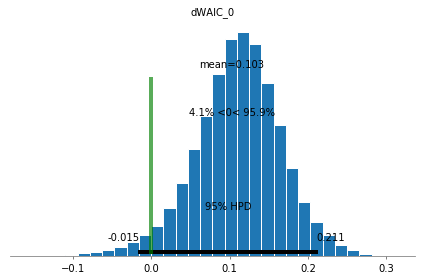

In [16]:
plot_posterior(m.backend.trace, varnames=['dWAIC'], ref_val=0)

In [18]:
result_path = os.path.join('results', 'mixed_effects_models', '2_relative_model_comparison_d_gaze_influence.csv')
if not os.path.isfile(result_path):
    m = Model(mfx_df)
    d_gaze_influence_fit = m.fit('gaze_influence ~ dWAIC', 
                                 random=['dWAIC|dataset'],
                                 categorical=['dataset'],
                                 samples=n_samples)
    d_summary = d_gaze_influence_fit.summary(ranefs=True)
    d_summary.to_csv(result_path)
else:
    print('Previous results loaded from "{}"...'.format(result_path))
    d_summary = pd.read_csv(result_path, index_col=0)
d_summary

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 449.1:  54%|█████▎    | 26781/50000 [00:20<00:17, 1329.95it/s] 
Convergence archived at 26800
Interrupted at 26,799 [53%]: Average Loss = 1,056.7
Sequential sampling (2 chains in 1 job)
NUTS: [gaze_influence_sd_interval__, dWAIC|dataset_offset, dWAIC|dataset_sd_log__, 1|dataset_offset, 1|dataset_sd_log__, dWAIC, Intercept]
100%|██████████| 20500/20500 [07:10<00:00, 47.58it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],2.542463,3.554145,-3.612844,10.504311,12819,1.000273
1|dataset[krajbich2010],-1.799756,3.149040,-8.762389,3.824061,10559,1.000244
1|dataset[krajbich2011],1.137361,3.121078,-4.901180,7.921761,12084,1.000348
1|dataset[tavares2017],-2.966423,3.613042,-10.669983,3.268770,10568,1.000281
1|dataset_sd,4.505407,3.281120,0.002046,10.768861,6860,0.999990
Intercept,11.214829,3.002903,5.211482,17.468055,10611,1.000348
dWAIC,-0.209068,0.110745,-0.422441,0.013970,5325,1.000557
dWAIC|dataset[folke2016],-0.085052,0.115627,-0.318578,0.136788,5808,1.000459
dWAIC|dataset[krajbich2010],-0.620017,0.134930,-0.876955,-0.351792,6893,1.000324
dWAIC|dataset[krajbich2011],-0.124864,0.114792,-0.357671,0.094294,5803,1.000545


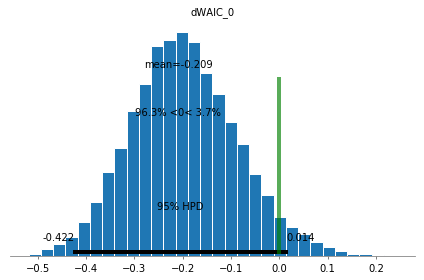

In [19]:
plot_posterior(m.backend.trace, varnames=['dWAIC'], ref_val=0)

# Plot DIC differences between full and no-gaze bias GLAM variant

In [16]:
def figure_4(waic, colors=None, fontsize=8, figsize=(7.5, 2.5), plot_type='bar', log_scale=False, ylim=(-100, 5)):

    # Log transform: add minimum dWAIC + 1, then log-transform, new indifference then at log(minimum dWAIC + 1)
    waic = waic.copy()
    if log_scale:
        min_dWAIC = np.min(waic['dWAIC'])
        indifference_level = np.log(np.abs(min_dWAIC) + 1)
        waic['plotted_dWAIC'] = np.log(waic['dWAIC'] + np.abs(min_dWAIC) + 1)
    else:
        indifference_level = 0
        waic['plotted_dWAIC'] = waic['dWAIC']
    
    if colors is None:
        colors = np.array(['C{}'.format(i) for i in range(10)])

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']
    dataset_labels = ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017']
    
    fig = plt.figure(figsize=figsize)

    ax0 = plt.subplot2grid((1, 3), (0, 0))
    ax1 = plt.subplot2grid((1, 3), (0, 1), colspan=2)

    sorting_idx = np.argsort(waic['plotted_dWAIC'])
    color_idx = pd.Categorical(waic['dataset'], categories=datasets).codes
    patches = []
    
    for i, dataset in enumerate(datasets):
        
        if plot_type == 'bar':
            ax1.bar(np.arange(len(waic))[waic['dataset'][sorting_idx] == dataset],
                        waic['plotted_dWAIC'][sorting_idx][waic['dataset'][sorting_idx] == dataset],
                        color=colors[i])
        
        else:
            ax1.scatter(np.arange(len(waic))[waic['dataset'][sorting_idx] == dataset],
                        waic['plotted_dWAIC'][sorting_idx][waic['dataset'][sorting_idx] == dataset],
                        color=colors[i], marker='+')
        
        bars = ax0.bar(i, 100 * np.mean(waic.loc[waic['dataset'] == dataset, 'dWAIC'] < 0), color=colors[i])
        patches.append(bars[0])        

    # Legend
    ax1.legend(patches,
               ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
               ncol=2,
               loc='lower right',
               handlelength=1, handleheight=1,
               fontsize=6, columnspacing=1,
               frameon=False)
    
    # Labels    
    ax0.tick_params(axis='both', which='major', labelsize=fontsize)
    ax0.set_xticks(np.arange(len(datasets)))
    ax0.set_xticklabels(dataset_labels, fontsize=fontsize, rotation=45)
    ax0.set_yticks(np.arange(0, 110, 20))
    ax0.set_ylim(0, 100)
    ax0.set_ylabel('% Participants\nwith gaze bias')
    
    ax1.set_xlabel('Participant', fontsize=fontsize)
    if log_scale:
        ax1.set_ylabel('Log(dWAIC))', fontsize=fontsize)
    else:
        ax1.set_ylabel('WAIC(gaze bias)-\nWAIC(no bias)')
    ax1.set_xticks([])
    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    
    
    ax1.axhline(indifference_level, color='black', lw=1, zorder=9)
    
    ax1.set_ylim(ylim)
    
    # Labels
    ax0.text(-0.4, 1.05, 'a', transform=ax0.transAxes,
            fontsize=12, fontweight='bold', va='top')
    
    ax1.text(-0.175, 1.05, 'b', transform=ax1.transAxes,
            fontsize=12, fontweight='bold', va='top')
    
    
        
    fig.tight_layout()
    
    return fig

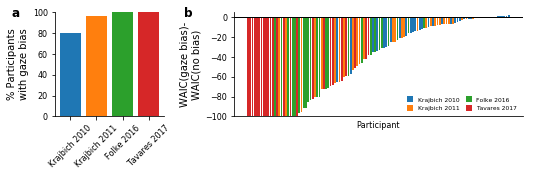

In [17]:
fig = figure_4(waic);
fig.savefig('results/figures/figure_4_relative_model_comparison.png', dpi=330, bbox_inches='tight')
plt.show()